IBM Data Science Capstone project MMK

<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in Rotterdam and the Hague Cities</font></h1>

## Introduction

In this project, South Holland addresses are converted into their equivalent latitude and longitude values. Following that using the Foursquare API to explore neighborhoods in Rotterdam and the Hague cities. Using the **explore** function to get the venue categories in each neighborhood, and then using this feature the restaurants are grouped into clusters with *k*-means clustering algorithm to complete this task. Finally, the Folium library is used to visualize the neighborhoods (restaurants) in Rotterdam and the Hague cities and their emerging clusters.  

#### This project is carried out to complete IBM Capstone project assignment.

Before I get the data and start exploring it, I will download all the dependencies that are needed.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import requests # library to handle requests
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import csv
from bs4 import BeautifulSoup
from urllib.request import urlopen

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported. Geopy and folium already installed.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

   

## 1. Download and Explore Dataset

Neighborhood (name) and boroughs (municipality) in the table. In order to segement the neighborhoods and explore them, I used the dataset that contains the municipality and the name as well as the the latitude and longitude coordinates of each neighborhood. 

This dataset exists for free on the web. Feel free to try to find this dataset on your own: https://en.wikipedia.org/wiki/List_of_cities,_towns_and_villages_in_South_Holland

#### Load and explore the data  
Next, let's load the data.

### The focus of this project is on clustering resturants in South Holland province of the Netherlands.  

List of cities, towns and villages in South Holland  
From Wikipedia, the free encyclopedia

In [3]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_cities,_towns_and_villages_in_South_Holland').text
soup = BeautifulSoup(source, 'lxml')
#print(soup.prettify())

#### For scraping BeautifulSoup is used which is one of the available libraries and packages of Python. 

In [4]:
ttable = soup.find('table',{'class':'wikitable sortable'})
#print(ttable.prettify())

Data is available in a table format under:Name, Municipality, Coordinates, Notes columns. These columns are renamed as Neighborhood, Borough, Coordinates, Notes.

#### Tranform the data into a *pandas* dataframe

In [5]:
rtab = ttable.findAll('tr')

res = []
for tr in rtab:
    td = tr.findAll('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        res.append(row)
        
df_rdata = pd.DataFrame(res, columns=["Neighborhood", "Borough", "Coordinates","Notes"])

In [6]:
df_rdata.head()

,Neighborhood,Borough,Coordinates,Notes
0,Aardam,Nieuwkoop,52°9′57″N 4°42′00″E﻿ / ﻿52.16583°N 4.70000°E﻿ ...,Former hamlet.
1,Aarlanderveen,Alphen aan den Rijn,52°08′25″N 4°43′40″E﻿ / ﻿52.14028°N 4.72778°E﻿...,None
2,Abbenbroek,Nissewaard,51°50′55″N 4°14′35″E﻿ / ﻿51.84861°N 4.24306°E﻿...,None
3,Abtswoude,Delft,51°58′45″N 4°21′20″E﻿ / ﻿51.97917°N 4.35556°E﻿...,None
4,Achterbroek,Krimpenerwaard,51°58′00″N 4°41′55″E﻿ / ﻿51.96667°N 4.69861°E﻿...,None


Notes column is not necessary and this column is dropped.

In [7]:
df_rdata.drop(columns =["Notes"], inplace = True)

In [8]:
df_rdata.head()

,Neighborhood,Borough,Coordinates
0,Aardam,Nieuwkoop,52°9′57″N 4°42′00″E﻿ / ﻿52.16583°N 4.70000°E﻿ ...
1,Aarlanderveen,Alphen aan den Rijn,52°08′25″N 4°43′40″E﻿ / ﻿52.14028°N 4.72778°E﻿...
2,Abbenbroek,Nissewaard,51°50′55″N 4°14′35″E﻿ / ﻿51.84861°N 4.24306°E﻿...
3,Abtswoude,Delft,51°58′45″N 4°21′20″E﻿ / ﻿51.97917°N 4.35556°E﻿...
4,Achterbroek,Krimpenerwaard,51°58′00″N 4°41′55″E﻿ / ﻿51.96667°N 4.69861°E﻿...


#### Rotterdam: Borough (municipality) of South Holland, is the focus of this project.

Den Haag (The Hague): Borough (municipality) of South Holland, is the focus of this project.

In [9]:
newc = df_rdata["Coordinates"].str.split("/", n = 2, expand = True)

In [10]:
df_rdata["A"] = newc[1]

In [11]:
newcd = df_rdata["Coordinates"].str.split(" ", n = 2, expand = True)
df_rdata["AD"] = newcd[2]

#### Coordinates column  is consist of several codes separated by / with N and E, also special symbols are included as well. Therefore, in multi steps latitude and longitude are extracted.

In [12]:
df_rdata.head()

,Neighborhood,Borough,Coordinates,A,AD
0,Aardam,Nieuwkoop,52°9′57″N 4°42′00″E﻿ / ﻿52.16583°N 4.70000°E﻿ ...,﻿52.16583°N 4.70000°E﻿,/ ﻿52.16583°N 4.70000°E﻿ / 52.16583; 4.70000﻿ ...
1,Aarlanderveen,Alphen aan den Rijn,52°08′25″N 4°43′40″E﻿ / ﻿52.14028°N 4.72778°E﻿...,﻿52.14028°N 4.72778°E﻿,/ ﻿52.14028°N 4.72778°E﻿ / 52.14028; 4.72778﻿ ...
2,Abbenbroek,Nissewaard,51°50′55″N 4°14′35″E﻿ / ﻿51.84861°N 4.24306°E﻿...,﻿51.84861°N 4.24306°E﻿,/ ﻿51.84861°N 4.24306°E﻿ / 51.84861; 4.24306﻿ ...
3,Abtswoude,Delft,51°58′45″N 4°21′20″E﻿ / ﻿51.97917°N 4.35556°E﻿...,﻿51.97917°N 4.35556°E﻿,/ ﻿51.97917°N 4.35556°E﻿ / 51.97917; 4.35556﻿ ...
4,Achterbroek,Krimpenerwaard,51°58′00″N 4°41′55″E﻿ / ﻿51.96667°N 4.69861°E﻿...,﻿51.96667°N 4.69861°E﻿,/ ﻿51.96667°N 4.69861°E﻿ / 51.96667; 4.69861﻿ ...


In [13]:
newc = df_rdata["AD"].str.split("/", n = 1, expand = True)
df_rdata["lat"] = newc[1]
newc = df_rdata["lat"].str.split("/", n = 1, expand = True)
df_rdata["lati"] = newc[1]
newc = df_rdata["lati"].str.split(";", n = 1, expand = True)
df_rdata["latitude"] = newc[0]

In [14]:
df_rdata.head()

,Neighborhood,Borough,Coordinates,A,AD,lat,lati,latitude
0,Aardam,Nieuwkoop,52°9′57″N 4°42′00″E﻿ / ﻿52.16583°N 4.70000°E﻿ ...,﻿52.16583°N 4.70000°E﻿,/ ﻿52.16583°N 4.70000°E﻿ / 52.16583; 4.70000﻿ ...,﻿52.16583°N 4.70000°E﻿ / 52.16583; 4.70000﻿ (...,52.16583; 4.70000﻿ (Aardam),52.16583
1,Aarlanderveen,Alphen aan den Rijn,52°08′25″N 4°43′40″E﻿ / ﻿52.14028°N 4.72778°E﻿...,﻿52.14028°N 4.72778°E﻿,/ ﻿52.14028°N 4.72778°E﻿ / 52.14028; 4.72778﻿ ...,﻿52.14028°N 4.72778°E﻿ / 52.14028; 4.72778﻿ (...,52.14028; 4.72778﻿ (Aarlanderveen),52.14028
2,Abbenbroek,Nissewaard,51°50′55″N 4°14′35″E﻿ / ﻿51.84861°N 4.24306°E﻿...,﻿51.84861°N 4.24306°E﻿,/ ﻿51.84861°N 4.24306°E﻿ / 51.84861; 4.24306﻿ ...,﻿51.84861°N 4.24306°E﻿ / 51.84861; 4.24306﻿ (...,51.84861; 4.24306﻿ (Abbenbroek),51.84861
3,Abtswoude,Delft,51°58′45″N 4°21′20″E﻿ / ﻿51.97917°N 4.35556°E﻿...,﻿51.97917°N 4.35556°E﻿,/ ﻿51.97917°N 4.35556°E﻿ / 51.97917; 4.35556﻿ ...,﻿51.97917°N 4.35556°E﻿ / 51.97917; 4.35556﻿ (...,51.97917; 4.35556﻿ (Abtswoude),51.97917
4,Achterbroek,Krimpenerwaard,51°58′00″N 4°41′55″E﻿ / ﻿51.96667°N 4.69861°E﻿...,﻿51.96667°N 4.69861°E﻿,/ ﻿51.96667°N 4.69861°E﻿ / 51.96667; 4.69861﻿ ...,﻿51.96667°N 4.69861°E﻿ / 51.96667; 4.69861﻿ (...,51.96667; 4.69861﻿ (Achterbroek),51.96667


In [15]:
newc = df_rdata["A"].str.split(" ", n = 1, expand = True)
df_rdata["lon"] = newc[1]
newc = df_rdata["lon"].str.split("°N", n = 1, expand = True)
df_rdata["longi"] = newc[1]
newc = df_rdata["longi"].str.split("°E", n = 1, expand = True)
df_rdata["longitude"] = newc[0]

In [16]:
df_rdata.head()

,Neighborhood,Borough,Coordinates,A,AD,lat,lati,latitude,lon,longi,longitude
0,Aardam,Nieuwkoop,52°9′57″N 4°42′00″E﻿ / ﻿52.16583°N 4.70000°E﻿ ...,﻿52.16583°N 4.70000°E﻿,/ ﻿52.16583°N 4.70000°E﻿ / 52.16583; 4.70000﻿ ...,﻿52.16583°N 4.70000°E﻿ / 52.16583; 4.70000﻿ (...,52.16583; 4.70000﻿ (Aardam),52.16583,﻿52.16583°N 4.70000°E﻿,4.70000°E﻿,4.70000
1,Aarlanderveen,Alphen aan den Rijn,52°08′25″N 4°43′40″E﻿ / ﻿52.14028°N 4.72778°E﻿...,﻿52.14028°N 4.72778°E﻿,/ ﻿52.14028°N 4.72778°E﻿ / 52.14028; 4.72778﻿ ...,﻿52.14028°N 4.72778°E﻿ / 52.14028; 4.72778﻿ (...,52.14028; 4.72778﻿ (Aarlanderveen),52.14028,﻿52.14028°N 4.72778°E﻿,4.72778°E﻿,4.72778
2,Abbenbroek,Nissewaard,51°50′55″N 4°14′35″E﻿ / ﻿51.84861°N 4.24306°E﻿...,﻿51.84861°N 4.24306°E﻿,/ ﻿51.84861°N 4.24306°E﻿ / 51.84861; 4.24306﻿ ...,﻿51.84861°N 4.24306°E﻿ / 51.84861; 4.24306﻿ (...,51.84861; 4.24306﻿ (Abbenbroek),51.84861,﻿51.84861°N 4.24306°E﻿,4.24306°E﻿,4.24306
3,Abtswoude,Delft,51°58′45″N 4°21′20″E﻿ / ﻿51.97917°N 4.35556°E﻿...,﻿51.97917°N 4.35556°E﻿,/ ﻿51.97917°N 4.35556°E﻿ / 51.97917; 4.35556﻿ ...,﻿51.97917°N 4.35556°E﻿ / 51.97917; 4.35556﻿ (...,51.97917; 4.35556﻿ (Abtswoude),51.97917,﻿51.97917°N 4.35556°E﻿,4.35556°E﻿,4.35556
4,Achterbroek,Krimpenerwaard,51°58′00″N 4°41′55″E﻿ / ﻿51.96667°N 4.69861°E﻿...,﻿51.96667°N 4.69861°E﻿,/ ﻿51.96667°N 4.69861°E﻿ / 51.96667; 4.69861﻿ ...,﻿51.96667°N 4.69861°E﻿ / 51.96667; 4.69861﻿ (...,51.96667; 4.69861﻿ (Achterbroek),51.96667,﻿51.96667°N 4.69861°E﻿,4.69861°E﻿,4.69861


In [17]:
df_rdata.drop(columns =["Coordinates","A","AD","lat","lon","lati","longi"], inplace = True)

In [18]:
df_rdata.head()

,Neighborhood,Borough,latitude,longitude
0,Aardam,Nieuwkoop,52.16583,4.70000
1,Aarlanderveen,Alphen aan den Rijn,52.14028,4.72778
2,Abbenbroek,Nissewaard,51.84861,4.24306
3,Abtswoude,Delft,51.97917,4.35556
4,Achterbroek,Krimpenerwaard,51.96667,4.69861


In [19]:
df_rdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 4 columns):
Neighborhood    406 non-null object
Borough         406 non-null object
latitude        406 non-null object
longitude       406 non-null object
dtypes: object(4)
memory usage: 12.8+ KB


#### Data types of latitude and longitude needs to be converted to numeric in order to pass it to folium map.

In [20]:
cols = ["latitude","longitude"]
for col in cols:
    df_rdata[col] = pd.to_numeric(df_rdata[col])

In [21]:
df_rdata.head()

,Neighborhood,Borough,latitude,longitude
0,Aardam,Nieuwkoop,52.16583,4.70000
1,Aarlanderveen,Alphen aan den Rijn,52.14028,4.72778
2,Abbenbroek,Nissewaard,51.84861,4.24306
3,Abtswoude,Delft,51.97917,4.35556
4,Achterbroek,Krimpenerwaard,51.96667,4.69861


#### Use geopy library to get the latitude and longitude values of South Holland City.

In [22]:
address = 'South Holland, NL'

geolocator = Nominatim(user_agent="nl_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of South Holland in the Netherlands are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of South Holland in the Netherlands are 51.9966792, 4.5597397.


#### Create a map of South Holland with neighborhoods superimposed on top.

In [23]:
# create map of South Holland using latitude and longitude values
map_SoH = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map
for lat, lng, label in zip(df_rdata['latitude'], df_rdata['longitude'], df_rdata['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_SoH)  
    
map_SoH

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Rotterdam. So let's slice the original dataframe and create a new dataframe of the Rotterdam data.

Credentials for Foursquare are provided and stored.

In [24]:
# The code was removed by Watson Studio for sharing.

#### Let's explore the neighborhoods in the South Holland dataframe

In [25]:
print(df_rdata[df_rdata['Neighborhood'] == "Den Haag (The Hague)"])  
print(  )
print(df_rdata[df_rdata['Neighborhood'] == 'Rotterdam'])

            Neighborhood               Borough  latitude  longitude
71  Den Haag (The Hague)  Den Haag (The Hague)  52.07639    4.29861

    Neighborhood    Borough  latitude  longitude
297    Rotterdam  Rotterdam  51.92222    4.47917


#### Let's explore the first neighborhood in our dataframe

In [26]:
df_rdata.loc[71,'Neighborhood']
df_rdata.loc[297,'Neighborhood']

'Rotterdam'

In [27]:
df_d = df_rdata[df_rdata['Borough'] == "Den Haag (The Hague)"].reset_index(drop=True)
df_d.head()

,Neighborhood,Borough,latitude,longitude
0,Den Haag (The Hague),Den Haag (The Hague),52.07639,4.29861
1,Haagoord,Den Haag (The Hague),52.05972,4.40417


In [28]:
df_r = df_rdata[df_rdata['Borough'] == "Rotterdam"].reset_index(drop=True)
df_r.head()

,Neighborhood,Borough,latitude,longitude
0,Groeneweg,Rotterdam,51.98472,4.59722
1,Heijplaat,Rotterdam,51.89306,4.42083
2,Hoek van Holland,Rotterdam,51.97778,4.13333
3,Hoogvliet,Rotterdam,51.86250,4.36250
4,Kandelaar,Rotterdam,51.95694,4.39861


In [29]:
df_r.head(10)

,Neighborhood,Borough,latitude,longitude
0,Groeneweg,Rotterdam,51.98472,4.59722
1,Heijplaat,Rotterdam,51.89306,4.42083
2,Hoek van Holland,Rotterdam,51.97778,4.13333
3,Hoogvliet,Rotterdam,51.86250,4.36250
4,Kandelaar,Rotterdam,51.95694,4.39861
5,Kralingse Veer,Rotterdam,51.91250,4.55278
6,Oud Verlaat,Rotterdam,51.97917,4.55278
7,Pernis,Rotterdam,51.88889,4.38889
8,Rotterdam,Rotterdam,51.92222,4.47917
9,Rozenburg,Rotterdam,51.90417,4.24861


Get the neighborhood's latitude and longitude values.

In [30]:
d_neighborhood_latitude = df_d.loc[0, 'latitude'] # neighborhood latitude value
d_neighborhood_longitude = df_d.loc[0, 'longitude'] # neighborhood longitude value

d_neighborhood_name = df_d.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(d_neighborhood_name, 
                                                               d_neighborhood_latitude, 
                                                               d_neighborhood_longitude))

Latitude and longitude values of Den Haag (The Hague) are 52.07639, 4.29861.


In [31]:
neighborhood_latitude = df_r.loc[8, 'latitude'] # neighborhood latitude value
neighborhood_longitude = df_r.loc[8, 'longitude'] # neighborhood longitude value

neighborhood_name = df_r.loc[8, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Rotterdam are 51.92222, 4.47917.


### Now, let's get the top 100 venues that are in Rotterdam within a radius of 1000 meters.
First, let's create the GET request URL.

In [32]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

In [33]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1000 # define radius
d_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    d_neighborhood_latitude, 
    d_neighborhood_longitude, 
    radius, 
    LIMIT)

#### Data for venues are stored in json format and displayed.

In [34]:
results = requests.get(url).json()

In [35]:
d_results = requests.get(d_url).json()

From the Foursquare lab in the previous module, we know that all the information is in the items key. Before we proceed, let's borrow the get_category_type function from the Foursquare lab.

In [36]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [37]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.id','venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,id,categories,lat,lng
0,Sugo,54e35ace498e94443cfd14e5,Pizza Place,51.921030,4.477747
1,THOMS,5676cb0e498e19ce9f0f106f,Restaurant,51.921856,4.481555
2,Urban Residences Rotterdam,508aaff7e4b01ceeb29e0971,Residential Building (Apartment / Condo),51.920041,4.477572
3,Stadsbrouwerij Thoms,5b23df7895d986002c24dda9,Beer Garden,51.922837,4.480854
4,The James,5ae23ca865211f0039a4f537,Hotel,51.921074,4.477826


In [38]:
d_venues = d_results['response']['groups'][0]['items']
    
d_nearby_venues = json_normalize(d_venues) # flatten JSON

# filter columns
d_filtered_columns = ['venue.name', 'venue.id','venue.categories', 'venue.location.lat', 'venue.location.lng']
d_nearby_venues =d_nearby_venues.loc[:, d_filtered_columns]

# filter the category for each row
d_nearby_venues['venue.categories'] = d_nearby_venues.apply(get_category_type, axis=1)

# clean columns
d_nearby_venues.columns = [col.split(".")[-1] for col in d_nearby_venues.columns]

d_nearby_venues.head()

,name,id,categories,lat,lng
0,Baladi Manouche,555b50bd498e2843efb7c8c7,Bakery,52.078805,4.303832
1,Kua,52f529ae11d203e7b26d4453,Mexican Restaurant,52.078638,4.304469
2,Grapes&Olives,4cb8d4150180721e0db69061,Wine Bar,52.079949,4.303191
3,Korzo,4b42f16ef964a5201cdb25e3,Theater,52.078690,4.305699
4,Albert Heijn XL,4b10ff34f964a5204c7723e3,Supermarket,52.079887,4.295971


## 2. Explore Neighborhoods in South Holland

### Let's create a function to repeat the same process to all the neighborhoods in Rotterdam and Den Haag

In [39]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [40]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    d_venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        d_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        d_results = requests.get(d_url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        d_venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in d_results])

    d_nearby_venues = pd.DataFrame([item for d_venue_list in d_venues_list for item in d_venue_list])
    d_nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(d_nearby_venues)

#### Now the code to run the above function on each neighborhood and create a new dataframe called rotterdam_venues.

In [41]:
rotterdam_venues = getNearbyVenues(names=df_r['Neighborhood'],
                                   latitudes=df_r['latitude'],
                                   longitudes=df_r['longitude']
                                  )

Groeneweg
Heijplaat
Hoek van Holland
Hoogvliet
Kandelaar
Kralingse Veer
Oud Verlaat
Pernis
Rotterdam
Rozenburg
Terbregge
Zweth


#### Now the code to run the above function on each neighborhood and create a new dataframe called DenHaag_venues.

In [42]:
denhaag_venues = getNearbyVenues(names=df_d['Neighborhood'],
                                   latitudes=df_d['latitude'],
                                   longitudes=df_d['longitude']
                                  )

Den Haag (The Hague)
Haagoord


Let's check how many venues were returned for each neighborhood in Rotterdam

In [43]:
rotterdam_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Groeneweg,4,4,4,4,4,4
Heijplaat,13,13,13,13,13,13
Hoek van Holland,24,24,24,24,24,24
Hoogvliet,28,28,28,28,28,28
Kandelaar,4,4,4,4,4,4
Kralingse Veer,10,10,10,10,10,10
Oud Verlaat,9,9,9,9,9,9
Pernis,4,4,4,4,4,4
Rotterdam,100,100,100,100,100,100


Let's check how many venues were returned for each neighborhood in Den Haag

In [44]:
denhaag_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Den Haag (The Hague),100,100,100,100,100,100
Haagoord,26,26,26,26,26,26


#### Let's find out how many unique categories can be curated from all the returned venues in Rotterdam

In [45]:
print('There are {} unique categories.'.format(len(rotterdam_venues['Venue Category'].unique())))

There are 100 unique categories.


#### Let's find out how many unique categories can be curated from all the returned venues in Den Haag

In [46]:
print('There are {} unique categories.'.format(len(denhaag_venues['Venue Category'].unique())))

There are 80 unique categories.


## 3. Analyze Each Neighborhood

#### Neighborhood in Rotterdam

In [47]:
# Rotterdam
# one hot encoding
rotterdam_onehot = pd.get_dummies(rotterdam_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
rotterdam_onehot['Neighborhood'] = rotterdam_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [rotterdam_onehot.columns[-1]] + list(rotterdam_onehot.columns[:-1])
rotterdam_onehot = rotterdam_onehot[fixed_columns]

rotterdam_onehot.head()

,Neighborhood,American Restaurant,Argentinian Restaurant,Art Museum,Asian Restaurant,Auto Dealership,Bakery,Bar,Beach,Beer Garden,Board Shop,Boat or Ferry,Boutique,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Café,Casino,Chinese Restaurant,Clothing Store,Coffee Shop,Comic Shop,Concert Hall,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Diner,Discount Store,Dog Run,Drugstore,Eastern European Restaurant,Event Service,Farm,Fast Food Restaurant,Fishing Spot,Flower Shop,Food & Drink Shop,Food Truck,Forest,French Restaurant,Friterie,Furniture / Home Store,Gastropub,Gym,Gym / Fitness Center,Harbor / Marina,Historic Site,History Museum,Hotel,IT Services,Ice Cream Shop,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Market,Mediterranean Restaurant,Men's Store,Metro Station,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Multiplex,Nightclub,Noodle House,Office,Optical Shop,Park,Pet Store,Pier,Pizza Place,Playground,Plaza,Pop-Up Shop,Port,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shopping Mall,Ski Area,Smoke Shop,Snack Place,Soccer Field,Sporting Goods Shop,Sports Club,Supermarket,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Theater,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Groeneweg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Groeneweg,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Groeneweg,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Groeneweg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Heijplaat,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Neighborhood in Den Haag

In [48]:
# Den Haag
# one hot encoding
denhaag_onehot = pd.get_dummies(denhaag_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
denhaag_onehot['Neighborhood'] = denhaag_venues['Neighborhood'] 

# move neighborhood column to the first column
d_fixed_columns = [denhaag_onehot.columns[-1]] + list(denhaag_onehot.columns[:-1])
denhaag_onehot = denhaag_onehot[d_fixed_columns]

denhaag_onehot.head()

,Neighborhood,Arts & Crafts Store,Bagel Shop,Bakery,Bar,Beer Garden,Bike Shop,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Bus Stop,Butcher,Café,Church,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Cosmetics Shop,Department Store,Diner,Electronics Store,Factory,Farm,Flower Shop,Food & Drink Shop,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,Greek Restaurant,Gym,Gym / Fitness Center,History Museum,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Light Rail Station,Marijuana Dispensary,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Miscellaneous Shop,Motorcycle Shop,Movie Theater,Multiplex,Music Store,Park,Pie Shop,Pizza Place,Plaza,Pool,Pub,Restaurant,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Shopping Mall,Smoke Shop,Soccer Field,Stadium,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Whisky Bar,Wine Bar
0,Den Haag (The Hague),0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Den Haag (The Hague),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Den Haag (The Hague),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Den Haag (The Hague),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,Den Haag (The Hague),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [49]:
#Rotterdam
rotterdam_grouped = rotterdam_onehot.groupby('Neighborhood').mean().reset_index()
rotterdam_grouped

,Neighborhood,American Restaurant,Argentinian Restaurant,Art Museum,Asian Restaurant,Auto Dealership,Bakery,Bar,Beach,Beer Garden,Board Shop,Boat or Ferry,Boutique,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Café,Casino,Chinese Restaurant,Clothing Store,Coffee Shop,Comic Shop,Concert Hall,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Diner,Discount Store,Dog Run,Drugstore,Eastern European Restaurant,Event Service,Farm,Fast Food Restaurant,Fishing Spot,Flower Shop,Food & Drink Shop,Food Truck,Forest,French Restaurant,Friterie,Furniture / Home Store,Gastropub,Gym,Gym / Fitness Center,Harbor / Marina,Historic Site,History Museum,Hotel,IT Services,Ice Cream Shop,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Market,Mediterranean Restaurant,Men's Store,Metro Station,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Multiplex,Nightclub,Noodle House,Office,Optical Shop,Park,Pet Store,Pier,Pizza Place,Playground,Plaza,Pop-Up Shop,Port,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shopping Mall,Ski Area,Smoke Shop,Snack Place,Soccer Field,Sporting Goods Shop,Sports Club,Supermarket,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Theater,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Groeneweg,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.250000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00
1,Heijplaat,0.076923,0.00,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.153846,0.00,0.00,0.00,0.000000,0.153846,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.076923,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.230769,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.000000,0.000000,0.076923,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.076923,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.076923,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00
2,Hoek van Holland,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.250000,0.00,0.00,0.00,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.041667,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.041667,0.041667,0.0,0.041667,0.000000,0.00,0.041667,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.041667,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.041667,0.00,0.00,0.083333,0.00,0.000000,0.041667,0.000000,0.000000,0.00,0.041667,0.041667,0.00,0.041667,0.125000,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00
3,Hoogvliet,0.000000,0.00,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.035714,0.000000,0.000000,0.035714,0.035714,0.00,0.00,0.00,0.00,0.00,0.00,0.035714,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.035714,0.035714,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.035714,0.000000,0.035714,0.107143,0.000000,0.00

In [50]:
#Den Haag
denhaag_grouped = denhaag_onehot.groupby('Neighborhood').mean().reset_index()
denhaag_grouped

,Neighborhood,Arts & Crafts Store,Bagel Shop,Bakery,Bar,Beer Garden,Bike Shop,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Bus Stop,Butcher,Café,Church,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Cosmetics Shop,Department Store,Diner,Electronics Store,Factory,Farm,Flower Shop,Food & Drink Shop,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,Greek Restaurant,Gym,Gym / Fitness Center,History Museum,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Light Rail Station,Marijuana Dispensary,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Miscellaneous Shop,Motorcycle Shop,Movie Theater,Multiplex,Music Store,Park,Pie Shop,Pizza Place,Plaza,Pool,Pub,Restaurant,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Shopping Mall,Smoke Shop,Soccer Field,Stadium,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Whisky Bar,Wine Bar
0,Den Haag (The Hague),0.01,0.01,0.04,0.04,0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.000000,0.01,0.03,0.01,0.01,0.01,0.05,0.01,0.000000,0.000000,0.01,0.02,0.01,0.000000,0.000000,0.01,0.03,0.01,0.010000,0.01,0.01,0.01,0.010000,0.000000,0.01,0.01,0.030000,0.000000,0.01,0.02,0.03,0.02,0.01,0.000000,0.01,0.01,0.01,0.000000,0.02,0.01,0.000000,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.000000,0.01,0.080000,0.01,0.030000,0.01,0.010000,0.01,0.000000,0.000000,0.010000,0.01,0.03,0.02,0.000000,0.000000,0.000000,0.02,0.01,0.01,0.01
1,Haagoord,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.038462,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.038462,0.038462,0.00,0.00,0.00,0.038462,0.038462,0.00,0.00,0.00,0.038462,0.00,0.00,0.00,0.038462,0.038462,0.00,0.00,0.038462,0.038462,0.00,0.00,0.00,0.00,0.00,0.038462,0.00,0.00,0.00,0.038462,0.00,0.00,0.038462,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.038462,0.00,0.076923,0.00,0.038462,0.00,0.038462,0.00,0.076923,0.038462,0.076923,0.00,0.00,0.00,0.038462,0.038462,0.038462,0.00,0.00,0.00,0.00


#### Let's put that into a pandas dataframe.  
First, let's write a function to sort the venues in descending order.

In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood in Rotterdam.

In [52]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = rotterdam_grouped['Neighborhood']

for ind in np.arange(rotterdam_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(rotterdam_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Groeneweg,Beach,Flower Shop,Metro Station,Yoga Studio,Diner
1,Heijplaat,Harbor / Marina,Bus Stop,Boat or Ferry,Supermarket,Food Truck
2,Hoek van Holland,Boat or Ferry,Supermarket,Restaurant,Drugstore,Bus Stop
3,Hoogvliet,Supermarket,Gym / Fitness Center,Metro Station,Shopping Mall,Furniture / Home Store
4,Kandelaar,Historic Site,Restaurant,French Restaurant,Monument / Landmark,Fast Food Restaurant


Now let's create the new dataframe and display the top 5 venues for each neighborhood in Den Haag.

In [53]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
d_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
d_neighborhoods_venues_sorted['Neighborhood'] = denhaag_grouped['Neighborhood']

for ind in np.arange(denhaag_grouped.shape[0]):
    d_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(denhaag_grouped.iloc[ind, :], num_top_venues)

d_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Den Haag (The Hague),Restaurant,Coffee Shop,Bakery,Bar,Café
1,Haagoord,Restaurant,Supermarket,Soccer Field,Furniture / Home Store,Shopping Mall


## 4. Cluster Neighborhoods

Run k-means to cluster the neighborhood into 3 clusters

In [54]:
#Rotterdam
# set number of clusters
kclusters = 3

rotterdam_grouped_clustering = rotterdam_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(rotterdam_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 1, 2, 1, 1, 1, 1, 1], dtype=int32)

In [55]:
#Den Haag
# set number of clusters
d_kclusters = 2

denhaag_grouped_clustering = denhaag_grouped.drop('Neighborhood', 1)

# run k-means clustering
d_kmeans = KMeans(n_clusters=d_kclusters, random_state=0).fit(denhaag_grouped_clustering)

# check cluster labels generated for each row in the dataframe
d_kmeans.labels_[0:10] 

array([0, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

In [56]:
#Rotterdam
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

rotterdam_merged = df_r

# merge rotterdam_grouped with df_r to add latitude/longitude for each neighborhood
rotterdam_merged = rotterdam_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

rotterdam_merged.head() # check the last columns!

,Neighborhood,Borough,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Groeneweg,Rotterdam,51.98472,4.59722,0,Beach,Flower Shop,Metro Station,Yoga Studio,Diner
1,Heijplaat,Rotterdam,51.89306,4.42083,1,Harbor / Marina,Bus Stop,Boat or Ferry,Supermarket,Food Truck
2,Hoek van Holland,Rotterdam,51.97778,4.13333,1,Boat or Ferry,Supermarket,Restaurant,Drugstore,Bus Stop
3,Hoogvliet,Rotterdam,51.86250,4.36250,1,Supermarket,Gym / Fitness Center,Metro Station,Shopping Mall,Furniture / Home Store
4,Kandelaar,Rotterdam,51.95694,4.39861,2,Historic Site,Restaurant,French Restaurant,Monument / Landmark,Fast Food Restaurant


In [57]:
#Den Haag
# add clustering labels
d_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', d_kmeans.labels_)

denhaag_merged = df_d

# merge denhaag_grouped with df_d to add latitude/longitude for each neighborhood
denhaag_merged = denhaag_merged.join(d_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

denhaag_merged.head() # check the last columns!

,Neighborhood,Borough,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Den Haag (The Hague),Den Haag (The Hague),52.07639,4.29861,0,Restaurant,Coffee Shop,Bakery,Bar,Café
1,Haagoord,Den Haag (The Hague),52.05972,4.40417,1,Restaurant,Supermarket,Soccer Field,Furniture / Home Store,Shopping Mall


#### Finally, let's visualize the resulting clusters

#### Rotterdam map

In [58]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(rotterdam_merged['latitude'], rotterdam_merged['longitude'], rotterdam_merged['Neighborhood'], rotterdam_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Den Haag map

In [59]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(d_kclusters)
ys = [i + x + (i*x)**2 for i in range(d_kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(denhaag_merged['latitude'], denhaag_merged['longitude'], denhaag_merged['Neighborhood'], denhaag_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster. First Rotterdam city clusters following that Den Haag (The Hague) clusters.

#### Rotterdam Cluster 1

In [60]:
rotterdam_merged.loc[rotterdam_merged['Cluster Labels'] == 0, rotterdam_merged.columns[[1] + list(range(3, rotterdam_merged.shape[1]))]]

,Borough,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Rotterdam,4.59722,0,Beach,Flower Shop,Metro Station,Yoga Studio,Diner


#### Rotterdam Cluster 2

In [61]:
rotterdam_merged.loc[rotterdam_merged['Cluster Labels'] == 1, rotterdam_merged.columns[[1] + list(range(3, rotterdam_merged.shape[1]))]]

,Borough,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Rotterdam,4.42083,1,Harbor / Marina,Bus Stop,Boat or Ferry,Supermarket,Food Truck
2,Rotterdam,4.13333,1,Boat or Ferry,Supermarket,Restaurant,Drugstore,Bus Stop
3,Rotterdam,4.36250,1,Supermarket,Gym / Fitness Center,Metro Station,Shopping Mall,Furniture / Home Store
5,Rotterdam,4.55278,1,Restaurant,Cosmetics Shop,IT Services,Office,Bar
6,Rotterdam,4.55278,1,Pet Store,Diner,Eastern European Restaurant,Bar,Beach
7,Rotterdam,4.38889,1,Harbor / Marina,Supermarket,Metro Station,Bus Station,Yoga Studio
8,Rotterdam,4.47917,1,Italian Restaurant,Bar,Coffee Shop,Hotel,Vegetarian / Vegan Restaurant
9,Rotterdam,4.24861,1,Supermarket,Gym,Soccer Field,Pizza Place,Drugstore
10,Rotterdam,4.51806,1,Harbor / Marina,Tennis Court,Diner,Dog Run,Auto Dealership


#### Rotterdam Cluster 3

In [62]:
rotterdam_merged.loc[rotterdam_merged['Cluster Labels'] == 2, rotterdam_merged.columns[[1] + list(range(3, rotterdam_merged.shape[1]))]]

,Borough,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Rotterdam,4.39861,2,Historic Site,Restaurant,French Restaurant,Monument / Landmark,Fast Food Restaurant
11,Rotterdam,4.39444,2,Farm,Fishing Spot,Restaurant,French Restaurant,Café


In [63]:
rotterdam_merged.sort_values(by=['Cluster Labels', 'Neighborhood'])

,Neighborhood,Borough,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Groeneweg,Rotterdam,51.98472,4.59722,0,Beach,Flower Shop,Metro Station,Yoga Studio,Diner
1,Heijplaat,Rotterdam,51.89306,4.42083,1,Harbor / Marina,Bus Stop,Boat or Ferry,Supermarket,Food Truck
2,Hoek van Holland,Rotterdam,51.97778,4.13333,1,Boat or Ferry,Supermarket,Restaurant,Drugstore,Bus Stop
3,Hoogvliet,Rotterdam,51.86250,4.36250,1,Supermarket,Gym / Fitness Center,Metro Station,Shopping Mall,Furniture / Home Store
5,Kralingse Veer,Rotterdam,51.91250,4.55278,1,Restaurant,Cosmetics Shop,IT Services,Office,Bar
6,Oud Verlaat,Rotterdam,51.97917,4.55278,1,Pet Store,Diner,Eastern European Restaurant,Bar,Beach
7,Pernis,Rotterdam,51.88889,4.38889,1,Harbor / Marina,Supermarket,Metro Station,Bus Station,Yoga Studio
8,Rotterdam,Rotterdam,51.92222,4.47917,1,Italian Restaurant,Bar,Coffee Shop,Hotel,Vegetarian / Vegan Restaurant
9,Rozenburg,Rotterdam,51.90417,4.24861,1,Supermarket,Gym,Soccer Field,Pizza Place,Drugstore
10,Terbregge,Rotterdam,51.95556,4.51806,1,Harbor / Marina,Tennis Court,Diner,Dog Run,Auto Dealership


#### Den Haag (the Hague) Cluster 1

In [64]:
denhaag_merged.loc[denhaag_merged['Cluster Labels'] == 0, denhaag_merged.columns[[1] + list(range(2, denhaag_merged.shape[1]))]]

,Borough,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Den Haag (The Hague),52.07639,4.29861,0,Restaurant,Coffee Shop,Bakery,Bar,Café


#### Den Haag (the Hague) Cluster 2

In [65]:
denhaag_merged.loc[denhaag_merged['Cluster Labels'] == 1, denhaag_merged.columns[[1] + list(range(2, denhaag_merged.shape[1]))]]

,Borough,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Den Haag (The Hague),52.05972,4.40417,1,Restaurant,Supermarket,Soccer Field,Furniture / Home Store,Shopping Mall


In [66]:
denhaag_merged.sort_values(by=['Cluster Labels', 'Neighborhood'])

,Neighborhood,Borough,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Den Haag (The Hague),Den Haag (The Hague),52.07639,4.29861,0,Restaurant,Coffee Shop,Bakery,Bar,Café
1,Haagoord,Den Haag (The Hague),52.05972,4.40417,1,Restaurant,Supermarket,Soccer Field,Furniture / Home Store,Shopping Mall


# Section 2

#### From list of retrieved venues, unique list is created.

In [67]:
#Rotterdam
nearby_venues['categories'].unique()

array(['Pizza Place', 'Restaurant',
       'Residential Building (Apartment / Condo)', 'Beer Garden', 'Hotel',
       'Theater', 'Ice Cream Shop', 'Sporting Goods Shop', 'Friterie',
       'Wine Bar', 'Gastropub', 'Bar', 'Cosmetics Shop',
       'Vegetarian / Vegan Restaurant', 'Vietnamese Restaurant',
       'Deli / Bodega', 'Clothing Store', 'Salon / Barbershop', 'Café',
       'Ramen Restaurant', 'Irish Pub', "Men's Store", 'Sandwich Place',
       'Italian Restaurant', 'Noodle House',
       'Molecular Gastronomy Restaurant', 'Supermarket', 'Food Truck',
       'Szechuan Restaurant', 'Seafood Restaurant', 'French Restaurant',
       'Furniture / Home Store', 'Coffee Shop', 'Comic Shop',
       'Chinese Restaurant', 'Pop-Up Shop', 'Jazz Club', 'Concert Hall',
       'Bubble Tea Shop', 'Tea Room', 'Market', 'Argentinian Restaurant',
       'Shopping Mall', 'Optical Shop', 'Boutique', 'Tapas Restaurant',
       'Miscellaneous Shop', 'Department Store', 'Plaza',
       'Asian Restauran

In [68]:
#Den Haag
d_nearby_venues['categories'].unique()

array(['Bakery', 'Mexican Restaurant', 'Wine Bar', 'Theater',
       'Supermarket', 'Restaurant', 'Vegetarian / Vegan Restaurant',
       'Breakfast Spot', 'Pie Shop', 'Coffee Shop', 'Sandwich Place',
       'Café', 'Jazz Club', 'Italian Restaurant', 'Ice Cream Shop', 'Bar',
       'Concert Hall', 'Scandinavian Restaurant', 'Thai Restaurant',
       'Church', 'Hostel', 'Whisky Bar', 'Pizza Place', 'Garden',
       'Indonesian Restaurant', 'French Restaurant', 'Music Store',
       'Arts & Crafts Store', 'Brewery', 'Sushi Restaurant',
       'Japanese Restaurant', 'Miscellaneous Shop', 'Electronics Store',
       'Mediterranean Restaurant', 'Beer Garden', 'Bike Shop',
       'Greek Restaurant', 'Pub', 'Video Game Store', 'Cocktail Bar',
       'Bookstore', 'Park', 'Furniture / Home Store', 'Gym',
       'Clothing Store', 'Hotel', 'Movie Theater', 'Bagel Shop',
       'Gastropub', 'Plaza', 'Frozen Yogurt Shop', "Men's Store",
       'Smoke Shop', 'Diner', 'Bubble Tea Shop', 'Factory',
  

#### Among the categories only the categories which specifically mentioned 'Restaurant' is filtered.

In [69]:
#Rotterdam
nearby_venuesR = nearby_venues[nearby_venues['categories'].str.contains('Restaurant')].reset_index(drop=True)

In [70]:
#Den Haag
d_nearby_venuesR = d_nearby_venues[d_nearby_venues['categories'].str.contains('Restaurant')].reset_index(drop=True)

Number of venues were returned by Foursquare.

In [71]:
#Rotterdam
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
print('{} Restaurant venues were returned by Foursquare.'.format(nearby_venuesR.shape[0]))

100 venues were returned by Foursquare.
24 Restaurant venues were returned by Foursquare.


In [72]:
#Den Haag
print('{} venues were returned by Foursquare.'.format(d_nearby_venues.shape[0]))
print('{} Restaurant venues were returned by Foursquare.'.format(d_nearby_venuesR.shape[0]))

100 venues were returned by Foursquare.
29 Restaurant venues were returned by Foursquare.


In [73]:
#Rotterdam
nearby_venuesR.head()

,name,id,categories,lat,lng
0,THOMS,5676cb0e498e19ce9f0f106f,Restaurant,51.921856,4.481555
1,Roots Rotterdam,50cb82bce4b0262ed982ed88,Restaurant,51.923667,4.477332
2,Bertmans,5adb0538018cbb0f94b63923,Vegetarian / Vegan Restaurant,51.920812,4.474312
3,Little V,4b5c9d93f964a520173a29e3,Vietnamese Restaurant,51.921807,4.484580
4,Backyard,5afadf1adec1d6002cdec318,Vegetarian / Vegan Restaurant,51.919667,4.482279


In [74]:
#Den Haag
d_nearby_venuesR.head()

,name,id,categories,lat,lng
0,Kua,52f529ae11d203e7b26d4453,Mexican Restaurant,52.078638,4.304469
1,Juni,4b409643f964a52029b925e3,Restaurant,52.076651,4.306936
2,Hagedis,4b254ce1f964a520986f24e3,Vegetarian / Vegan Restaurant,52.078356,4.292688
3,Giuliano's,4b1ff42cf964a520462b24e3,Italian Restaurant,52.076784,4.307886
4,Bøg,54cbbea7498ede96b0832ffa,Scandinavian Restaurant,52.079956,4.303943


## 2.1. Explore Neighborhoods in Rotterdam and Den Haag

#### Let's create a function to repeat the same process to all the neighborhoods in Rotterdam in Den Haag

In order to retrieve number of likes for each of the venue (Restaurant) id for each of the venue is stored in a list.

In [75]:
#Rotterdam
venueR_id_list = nearby_venuesR['id'].tolist()

In [76]:
#Den Haag
d_venueR_id_list = d_nearby_venuesR['id'].tolist()

#### For each of Restaurant total number of likes are counted.

In [77]:
#Rotterdam
urlList = []
likeList = []

for r in venueR_id_list:
    venueR_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(r,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
    urlList.append(venueR_url)

for link in urlList:
        result = requests.get(link).json()
        likes = result['response']['likes']['count']
        likeList.append(likes)
print(likeList)

[132, 30, 41, 291, 13, 16, 98, 90, 57, 27, 39, 31, 52, 30, 31, 38, 251, 32, 189, 28, 53, 240, 98, 102]


In [78]:
#Den Haag
d_urlList = []
d_likeList = []

for dr in d_venueR_id_list:
    d_venueR_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(dr,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
    d_urlList.append(d_venueR_url)

for link in d_urlList:
        d_result = requests.get(link).json()
        likes = d_result['response']['likes']['count']
        d_likeList.append(likes)
print(d_likeList)

[64, 36, 16, 87, 18, 10, 9, 10, 21, 35, 18, 110, 91, 6, 50, 77, 22, 23, 10, 35, 33, 23, 31, 63, 50, 15, 54, 25, 174]


#### Confirming elements of the list based on the number of restaurants. 

In [79]:
#Rotterdam
print(len(likeList))
print(len(venueR_id_list))

24
24


In [80]:
#Den Haag
print(len(d_likeList))
print(len(d_venueR_id_list))

29
29


For further process of a copy of the dataframe is created.

In [81]:
#Rotterdam
venueRlist = nearby_venuesR.copy()
venueRlist.head()

,name,id,categories,lat,lng
0,THOMS,5676cb0e498e19ce9f0f106f,Restaurant,51.921856,4.481555
1,Roots Rotterdam,50cb82bce4b0262ed982ed88,Restaurant,51.923667,4.477332
2,Bertmans,5adb0538018cbb0f94b63923,Vegetarian / Vegan Restaurant,51.920812,4.474312
3,Little V,4b5c9d93f964a520173a29e3,Vietnamese Restaurant,51.921807,4.484580
4,Backyard,5afadf1adec1d6002cdec318,Vegetarian / Vegan Restaurant,51.919667,4.482279


In [82]:
#Den Haag
d_venueRlist = d_nearby_venuesR.copy()
d_venueRlist.head()

,name,id,categories,lat,lng
0,Kua,52f529ae11d203e7b26d4453,Mexican Restaurant,52.078638,4.304469
1,Juni,4b409643f964a52029b925e3,Restaurant,52.076651,4.306936
2,Hagedis,4b254ce1f964a520986f24e3,Vegetarian / Vegan Restaurant,52.078356,4.292688
3,Giuliano's,4b1ff42cf964a520462b24e3,Italian Restaurant,52.076784,4.307886
4,Bøg,54cbbea7498ede96b0832ffa,Scandinavian Restaurant,52.079956,4.303943


A new column (total likes) is added to the dataframe.

In [83]:
#Rotterdam
venueRlist['total likes'] = likeList
venueRlist.head()

,name,id,categories,lat,lng,total likes
0,THOMS,5676cb0e498e19ce9f0f106f,Restaurant,51.921856,4.481555,132
1,Roots Rotterdam,50cb82bce4b0262ed982ed88,Restaurant,51.923667,4.477332,30
2,Bertmans,5adb0538018cbb0f94b63923,Vegetarian / Vegan Restaurant,51.920812,4.474312,41
3,Little V,4b5c9d93f964a520173a29e3,Vietnamese Restaurant,51.921807,4.484580,291
4,Backyard,5afadf1adec1d6002cdec318,Vegetarian / Vegan Restaurant,51.919667,4.482279,13


In [84]:
#Den Haag
d_venueRlist['total likes'] = d_likeList
d_venueRlist.head()

,name,id,categories,lat,lng,total likes
0,Kua,52f529ae11d203e7b26d4453,Mexican Restaurant,52.078638,4.304469,64
1,Juni,4b409643f964a52029b925e3,Restaurant,52.076651,4.306936,36
2,Hagedis,4b254ce1f964a520986f24e3,Vegetarian / Vegan Restaurant,52.078356,4.292688,16
3,Giuliano's,4b1ff42cf964a520462b24e3,Italian Restaurant,52.076784,4.307886,87
4,Bøg,54cbbea7498ede96b0832ffa,Scandinavian Restaurant,52.079956,4.303943,18


#### Finding the statistical analysis of the dataframe.

In [85]:
#Rotterdam
venueRlist['total likes'].describe()

count     24.000000
mean      83.708333
std       80.233615
min       13.000000
25%       30.750000
50%       46.500000
75%       99.000000
max      291.000000
Name: total likes, dtype: float64

In [86]:
#Den Haag
d_venueRlist['total likes'].describe()

count     29.000000
mean      41.931034
std       37.367797
min        6.000000
25%       18.000000
50%       31.000000
75%       54.000000
max      174.000000
Name: total likes, dtype: float64

#### Histogram is ploted for the total number of likes based on the number of total likes category.

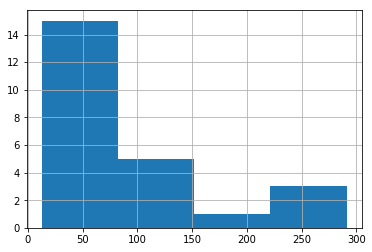

In [87]:
#Rotterdam
venueRlist['total likes'].hist(bins=4)
plt.show()

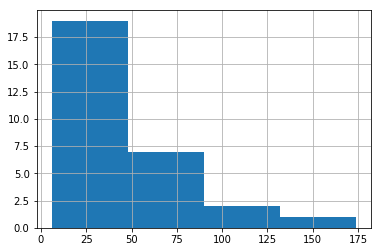

In [88]:
#Den Haag
d_venueRlist['total likes'].hist(bins=4)
plt.show()

#### Based on the total likes dataframe is divided into four categories based on the percentiles.

In [89]:
#Rotterdam
poor = venueRlist['total likes']<=30.75
fair = venueRlist[(venueRlist['total likes']>30.75) & (venueRlist['total likes']<=46.50)]
good = venueRlist[(venueRlist['total likes']>46.50) & (venueRlist['total likes']<=99.00)]
excellent = venueRlist['total likes']>99.00

In [90]:
#Den Haag
dpoor = d_venueRlist['total likes']<=18.0
dfair = d_venueRlist[(d_venueRlist['total likes']>18.0) & (d_venueRlist['total likes']<=31.0)]
dgood = d_venueRlist[(d_venueRlist['total likes']>31.0) & (d_venueRlist['total likes']<=54.0)]
dexcellent = d_venueRlist['total likes']>54.0

#### New column (satisfactory category) is added to classify restaurants based on the number of likes.

In [91]:
#Rotterdam
def conditions(c):
    if c['total likes']<=30.75:
        return 'Poor'
    elif c['total likes']<=46.50:
        return 'Fair'
    elif c['total likes']<=99.00:
        return 'Good'
    else:
        return 'Excellent'

venueRlist['satisfactory_category'] = venueRlist.apply(conditions, axis = 1)

In [92]:
#Den Haag
def conditions(d):
    if d['total likes']<=18.0:
        return 'Poor'
    elif d['total likes']<=31.0:
        return 'Fair'
    elif d['total likes']<=54.0:
        return 'Good'
    else:
        return 'Excellent'

d_venueRlist['satisfactory_category'] = d_venueRlist.apply(conditions, axis = 1)

In [93]:
#Rotterdam
venueRlist

,name,id,categories,lat,lng,total likes,satisfactory_category
0,THOMS,5676cb0e498e19ce9f0f106f,Restaurant,51.921856,4.481555,132,Excellent
1,Roots Rotterdam,50cb82bce4b0262ed982ed88,Restaurant,51.923667,4.477332,30,Poor
2,Bertmans,5adb0538018cbb0f94b63923,Vegetarian / Vegan Restaurant,51.920812,4.474312,41,Fair
3,Little V,4b5c9d93f964a520173a29e3,Vietnamese Restaurant,51.921807,4.484580,291,Excellent
4,Backyard,5afadf1adec1d6002cdec318,Vegetarian / Vegan Restaurant,51.919667,4.482279,13,Poor
5,Sapporo Ramen Kitchen,5b046a91772fbc002c150abe,Ramen Restaurant,51.920848,4.477738,16,Poor
6,Guliano,4b3b3e78f964a520c67125e3,Italian Restaurant,51.923580,4.485203,98,Good
7,FG Food Labs,52dfd2fc498e3ef839c37774,Molecular Gastronomy Restaurant,51.926249,4.479429,90,Good
8,Sānsān,4ebbb9d67bebd6a83f25067b,Szechuan Restaurant,51.919748,4.483493,57,Good
9,The Fish Market,57d9a14c498e43ee1a06441c,Seafood Restaurant,51.922762,4.485168,27,Poor


In [94]:
#Den Haag
d_venueRlist

,name,id,categories,lat,lng,total likes,satisfactory_category
0,Kua,52f529ae11d203e7b26d4453,Mexican Restaurant,52.078638,4.304469,64,Excellent
1,Juni,4b409643f964a52029b925e3,Restaurant,52.076651,4.306936,36,Good
2,Hagedis,4b254ce1f964a520986f24e3,Vegetarian / Vegan Restaurant,52.078356,4.292688,16,Poor
3,Giuliano's,4b1ff42cf964a520462b24e3,Italian Restaurant,52.076784,4.307886,87,Excellent
4,Bøg,54cbbea7498ede96b0832ffa,Scandinavian Restaurant,52.079956,4.303943,18,Poor
5,Waroeng Soeboer,4e2efdf6483b93c2f2dad2c9,Thai Restaurant,52.081116,4.296925,10,Poor
6,Ruen Thai,4b97d92cf964a520d31935e3,Thai Restaurant,52.078240,4.305759,9,Poor
7,Queru,5b3a73d87d849700393d8fbd,Mexican Restaurant,52.078630,4.306097,10,Poor
8,Soeboer,4b97d232f964a520d21735e3,Indonesian Restaurant,52.073141,4.305743,21,Fair
9,Pastis,4b66ff09f964a52034342be3,French Restaurant,52.079737,4.306629,35,Good


In [95]:
#Rotterdam
# one hot encoding
venueRlist_onehot = pd.get_dummies(venueRlist[['categories','satisfactory_category']], prefix="", prefix_sep="")

# add name column back to dataframe
venueRlist_onehot['name'] = venueRlist['name'] 

# move name column to the first column
fixed_columns = [venueRlist_onehot.columns[-1]] + list(venueRlist_onehot.columns[:-1])
venueRlist_onehot = venueRlist_onehot[fixed_columns]

venueRlist_onehot.head()

,name,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,French Restaurant,Italian Restaurant,Molecular Gastronomy Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Szechuan Restaurant,Tapas Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Excellent,Fair,Good,Poor
0,THOMS,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1,Roots Rotterdam,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,Bertmans,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,Little V,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
4,Backyard,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [96]:
#Den Haag
# one hot encoding
d_venueRlist_onehot = pd.get_dummies(d_venueRlist[['categories','satisfactory_category']], prefix="", prefix_sep="")

# add name column back to dataframe
d_venueRlist_onehot['name'] = d_venueRlist['name'] 

# move name column to the first column
d_fixed_columns = [d_venueRlist_onehot.columns[-1]] + list(d_venueRlist_onehot.columns[:-1])
d_venueRlist_onehot = d_venueRlist_onehot[d_fixed_columns]

d_venueRlist_onehot.head()

,name,French Restaurant,Greek Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Restaurant,Scandinavian Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Excellent,Fair,Good,Poor
0,Kua,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1,Juni,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,Hagedis,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,Giuliano's,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4,Bøg,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


## 2.2. Cluster Neighborhoods¶
#### Running k-means to cluster the neighborhood into 4 clusters.

In [97]:
#Rotterdam
# set number of clusters
kclusters = 4

venueRlist_onehot_clustering = venueRlist_onehot.drop('name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venueRlist_onehot_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 3, 0, 2, 3, 3, 1, 1, 1, 3], dtype=int32)

In [98]:
#Den Haag
# set number of clusters
d_kclusters = 4

d_venueRlist_onehot_clustering = d_venueRlist_onehot.drop('name', 1)

# run k-means clustering
d_kmeans = KMeans(n_clusters=d_kclusters, random_state=0).fit(d_venueRlist_onehot_clustering)

# check cluster labels generated for each row in the dataframe
d_kmeans.labels_[0:10]

array([0, 2, 1, 0, 1, 1, 1, 1, 3, 2], dtype=int32)

In [99]:
#Rotterdam
venueRlist['cluster labels'] = kmeans.labels_
venueRlist.head()

,name,id,categories,lat,lng,total likes,satisfactory_category,cluster labels
0,THOMS,5676cb0e498e19ce9f0f106f,Restaurant,51.921856,4.481555,132,Excellent,2
1,Roots Rotterdam,50cb82bce4b0262ed982ed88,Restaurant,51.923667,4.477332,30,Poor,3
2,Bertmans,5adb0538018cbb0f94b63923,Vegetarian / Vegan Restaurant,51.920812,4.474312,41,Fair,0
3,Little V,4b5c9d93f964a520173a29e3,Vietnamese Restaurant,51.921807,4.484580,291,Excellent,2
4,Backyard,5afadf1adec1d6002cdec318,Vegetarian / Vegan Restaurant,51.919667,4.482279,13,Poor,3


In [100]:
#Den Haag
d_venueRlist['cluster labels'] = d_kmeans.labels_
d_venueRlist.head()

,name,id,categories,lat,lng,total likes,satisfactory_category,cluster labels
0,Kua,52f529ae11d203e7b26d4453,Mexican Restaurant,52.078638,4.304469,64,Excellent,0
1,Juni,4b409643f964a52029b925e3,Restaurant,52.076651,4.306936,36,Good,2
2,Hagedis,4b254ce1f964a520986f24e3,Vegetarian / Vegan Restaurant,52.078356,4.292688,16,Poor,1
3,Giuliano's,4b1ff42cf964a520462b24e3,Italian Restaurant,52.076784,4.307886,87,Excellent,0
4,Bøg,54cbbea7498ede96b0832ffa,Scandinavian Restaurant,52.079956,4.303943,18,Poor,1


### Geographical coordinate of Rotterdam

In [101]:
address = 'Rotterdam, NL'

geolocator = Nominatim(user_agent="r_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Rotterdam in the Netherlands are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Rotterdam in the Netherlands are 51.9228934, 4.4631786.


### Creating Rotterdam map and marking each restaurant based on its cluster.

In [102]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venueRlist['lat'], venueRlist['lng'], venueRlist['name'], venueRlist['cluster labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Geographical coordinate of Den Haag

In [103]:
address = 'Den Haag, NL'

geolocator = Nominatim(user_agent="d_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Den Haag in the Netherlands are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Den Haag in the Netherlands are 52.07494555, 4.26968022053645.


### Creating Den Haag map and marking each restaurant based on its cluster.

In [104]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

# set color scheme for the clusters
x = np.arange(d_kclusters)
ys = [i + x + (i*x)**2 for i in range(d_kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(d_venueRlist['lat'], d_venueRlist['lng'], d_venueRlist['name'], d_venueRlist['cluster labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 2.3. Examine Clusters  
Now, examining each cluster and determining the discriminated restaurants categories that distinguish each cluster. Based on the defining categories, a name to each cluster is assigned.

### Cluster 1 - Rotterdam

In [105]:
venueRlist.loc[venueRlist['cluster labels'] == 0]

,name,id,categories,lat,lng,total likes,satisfactory_category,cluster labels
2,Bertmans,5adb0538018cbb0f94b63923,Vegetarian / Vegan Restaurant,51.920812,4.474312,41,Fair,0
10,Restaurant De Jong,50e5d2b5e4b0edb3f0e9ea81,French Restaurant,51.926222,4.478928,39,Fair,0
11,Chung,51af8a01498e52c3ec38d2ee,Chinese Restaurant,51.923066,4.482122,31,Fair,0
14,La Borsa,4c2f5c5b452620a184541d0f,Italian Restaurant,51.919638,4.479831,31,Fair,0
15,21 Pinchos,54b3aed1498eb40bca044dfd,Tapas Restaurant,51.920212,4.487548,38,Fair,0
17,Umami,5020f64ee4b0cc19ddf216cd,Asian Restaurant,51.922677,4.485775,32,Fair,0


### Cluster 2 - Rotterdam

In [106]:
venueRlist.loc[venueRlist['cluster labels'] == 1]

,name,id,categories,lat,lng,total likes,satisfactory_category,cluster labels
6,Guliano,4b3b3e78f964a520c67125e3,Italian Restaurant,51.923580,4.485203,98,Good,1
7,FG Food Labs,52dfd2fc498e3ef839c37774,Molecular Gastronomy Restaurant,51.926249,4.479429,90,Good,1
8,Sānsān,4ebbb9d67bebd6a83f25067b,Szechuan Restaurant,51.919748,4.483493,57,Good,1
12,Gauchos,4b44d8fef964a52008fe25e3,Argentinian Restaurant,51.920745,4.476284,52,Good,1
20,Mangiare,4b23976df964a520025724e3,Italian Restaurant,51.918882,4.473070,53,Good,1
22,Pierre,4d6d48f6423d5481f041ecb1,French Restaurant,51.923737,4.487523,98,Good,1


### Cluster 3 - Rotterdam

In [107]:
venueRlist.loc[venueRlist['cluster labels'] == 2]

,name,id,categories,lat,lng,total likes,satisfactory_category,cluster labels
0,THOMS,5676cb0e498e19ce9f0f106f,Restaurant,51.921856,4.481555,132,Excellent,2
3,Little V,4b5c9d93f964a520173a29e3,Vietnamese Restaurant,51.921807,4.484580,291,Excellent,2
16,Happy Italy,4dd69beae4cd37c89396c024,Italian Restaurant,51.922947,4.485218,251,Excellent,2
18,Spirit,4b4e0d42f964a520b5df26e3,Vegetarian / Vegan Restaurant,51.924282,4.488177,189,Excellent,2
21,Vapiano,510bb50be4b0ef517b7cd1df,Italian Restaurant,51.922971,4.471810,240,Excellent,2
23,Trattoria Gusto,4b0c4fb2f964a520f73a23e3,Italian Restaurant,51.916827,4.480223,102,Excellent,2


### Cluster 4 - Rotterdam

In [108]:
venueRlist.loc[venueRlist['cluster labels'] == 3]

,name,id,categories,lat,lng,total likes,satisfactory_category,cluster labels
1,Roots Rotterdam,50cb82bce4b0262ed982ed88,Restaurant,51.923667,4.477332,30,Poor,3
4,Backyard,5afadf1adec1d6002cdec318,Vegetarian / Vegan Restaurant,51.919667,4.482279,13,Poor,3
5,Sapporo Ramen Kitchen,5b046a91772fbc002c150abe,Ramen Restaurant,51.920848,4.477738,16,Poor,3
9,The Fish Market,57d9a14c498e43ee1a06441c,Seafood Restaurant,51.922762,4.485168,27,Poor,3
13,FG Restaurant,57a61463498e8c3c672a57d1,French Restaurant,51.926405,4.479447,30,Poor,3
19,Panzero,57cbf3d6498ece3480215857,Italian Restaurant,51.922108,4.488185,28,Poor,3


In [109]:
venueRlist.sort_values(['cluster labels', 'name'])

,name,id,categories,lat,lng,total likes,satisfactory_category,cluster labels
15,21 Pinchos,54b3aed1498eb40bca044dfd,Tapas Restaurant,51.920212,4.487548,38,Fair,0
2,Bertmans,5adb0538018cbb0f94b63923,Vegetarian / Vegan Restaurant,51.920812,4.474312,41,Fair,0
11,Chung,51af8a01498e52c3ec38d2ee,Chinese Restaurant,51.923066,4.482122,31,Fair,0
14,La Borsa,4c2f5c5b452620a184541d0f,Italian Restaurant,51.919638,4.479831,31,Fair,0
10,Restaurant De Jong,50e5d2b5e4b0edb3f0e9ea81,French Restaurant,51.926222,4.478928,39,Fair,0
17,Umami,5020f64ee4b0cc19ddf216cd,Asian Restaurant,51.922677,4.485775,32,Fair,0
7,FG Food Labs,52dfd2fc498e3ef839c37774,Molecular Gastronomy Restaurant,51.926249,4.479429,90,Good,1
12,Gauchos,4b44d8fef964a52008fe25e3,Argentinian Restaurant,51.920745,4.476284,52,Good,1
6,Guliano,4b3b3e78f964a520c67125e3,Italian Restaurant,51.923580,4.485203,98,Good,1
20,Mangiare,4b23976df964a520025724e3,Italian Restaurant,51.918882,4.473070,53,Good,1


### Cluster 1 - Den Haag (The Hague)

In [110]:
d_venueRlist.loc[d_venueRlist['cluster labels'] == 0]

,name,id,categories,lat,lng,total likes,satisfactory_category,cluster labels
0,Kua,52f529ae11d203e7b26d4453,Mexican Restaurant,52.078638,4.304469,64,Excellent,0
3,Giuliano's,4b1ff42cf964a520462b24e3,Italian Restaurant,52.076784,4.307886,87,Excellent,0
11,Bar & Restaurant Milú,53540f30498e27fc50d7534a,Restaurant,52.078222,4.307831,110,Excellent,0
12,SET Restaurant,4e592daa2271886714efcfc0,Japanese Restaurant,52.077037,4.307828,91,Excellent,0
15,Irodion,54f1ab4b498e6903bf159b9e,Greek Restaurant,52.075522,4.309413,77,Excellent,0
23,Het Heden,4b63282cf964a52019672ae3,Restaurant,52.082638,4.305330,63,Excellent,0
28,'t Goude Hooft,4b8d6472f964a52008f932e3,Restaurant,52.078294,4.308920,174,Excellent,0


### Cluster 2 - Den Haag (The Hague)

In [111]:
d_venueRlist.loc[d_venueRlist['cluster labels'] == 1]

,name,id,categories,lat,lng,total likes,satisfactory_category,cluster labels
2,Hagedis,4b254ce1f964a520986f24e3,Vegetarian / Vegan Restaurant,52.078356,4.292688,16,Poor,1
4,Bøg,54cbbea7498ede96b0832ffa,Scandinavian Restaurant,52.079956,4.303943,18,Poor,1
5,Waroeng Soeboer,4e2efdf6483b93c2f2dad2c9,Thai Restaurant,52.081116,4.296925,10,Poor,1
6,Ruen Thai,4b97d92cf964a520d31935e3,Thai Restaurant,52.078240,4.305759,9,Poor,1
7,Queru,5b3a73d87d849700393d8fbd,Mexican Restaurant,52.078630,4.306097,10,Poor,1
10,Kiraku,4b5f2d24f964a52033ab29e3,Sushi Restaurant,52.081223,4.302777,18,Poor,1
13,De Sierkan,55533add498ea01f88f182eb,Restaurant,52.076497,4.294133,6,Poor,1
18,De Sushimeisjes,56ec394d498e3b34b96af06a,Restaurant,52.081361,4.291992,10,Poor,1
25,Sapore,4b6316a9f964a5201d622ae3,Italian Restaurant,52.079761,4.306209,15,Poor,1


### Cluster 3 - Den Haag (The Hague)

In [112]:
d_venueRlist.loc[d_venueRlist['cluster labels'] == 2]

,name,id,categories,lat,lng,total likes,satisfactory_category,cluster labels
1,Juni,4b409643f964a52029b925e3,Restaurant,52.076651,4.306936,36,Good,2
9,Pastis,4b66ff09f964a52034342be3,French Restaurant,52.079737,4.306629,35,Good,2
14,Bleyenberg,596018838194fc3200a9f866,Mediterranean Restaurant,52.075157,4.308803,50,Good,2
19,SLA,57373bc2498ef5ee8e64f556,Vegetarian / Vegan Restaurant,52.077793,4.307002,35,Good,2
20,Brasserie Buitenhof,4c9e17652fb1a143d9afe640,French Restaurant,52.077765,4.310199,33,Good,2
24,ONI Japanese Dining,4aabe5cbf964a520c45a20e3,Japanese Restaurant,52.078787,4.306016,50,Good,2
26,Garoeda,4bb2265df964a520a3bd3ce3,Indonesian Restaurant,52.081080,4.308819,54,Good,2


### Cluster 4 - Den Haag (The Hague)

In [113]:
d_venueRlist.loc[d_venueRlist['cluster labels'] == 3]

,name,id,categories,lat,lng,total likes,satisfactory_category,cluster labels
8,Soeboer,4b97d232f964a520d21735e3,Indonesian Restaurant,52.073141,4.305743,21,Fair,3
16,Curry & Cocos,508c183be4b0e9aafa0f979b,Thai Restaurant,52.081590,4.292482,22,Fair,3
17,La Lanterna,4b27eac2f964a5204e8c24e3,Italian Restaurant,52.077486,4.307895,23,Fair,3
21,Palmette,58d7e96b005a0f4cb8b8e9e3,French Restaurant,52.079952,4.309963,23,Fair,3
22,St. Joris en de Draeck,4ba3e4c4f964a520e56a38e3,Restaurant,52.079990,4.288800,31,Fair,3
27,Zebedeüs,4aa6aabaf964a520924a20e3,Restaurant,52.077119,4.307172,25,Fair,3


In [114]:
d_venueRlist.sort_values(['cluster labels', 'name'])

,name,id,categories,lat,lng,total likes,satisfactory_category,cluster labels
28,'t Goude Hooft,4b8d6472f964a52008f932e3,Restaurant,52.078294,4.308920,174,Excellent,0
11,Bar & Restaurant Milú,53540f30498e27fc50d7534a,Restaurant,52.078222,4.307831,110,Excellent,0
3,Giuliano's,4b1ff42cf964a520462b24e3,Italian Restaurant,52.076784,4.307886,87,Excellent,0
23,Het Heden,4b63282cf964a52019672ae3,Restaurant,52.082638,4.305330,63,Excellent,0
15,Irodion,54f1ab4b498e6903bf159b9e,Greek Restaurant,52.075522,4.309413,77,Excellent,0
0,Kua,52f529ae11d203e7b26d4453,Mexican Restaurant,52.078638,4.304469,64,Excellent,0
12,SET Restaurant,4e592daa2271886714efcfc0,Japanese Restaurant,52.077037,4.307828,91,Excellent,0
4,Bøg,54cbbea7498ede96b0832ffa,Scandinavian Restaurant,52.079956,4.303943,18,Poor,1
13,De Sierkan,55533add498ea01f88f182eb,Restaurant,52.076497,4.294133,6,Poor,1
18,De Sushimeisjes,56ec394d498e3b34b96af06a,Restaurant,52.081361,4.291992,10,Poor,1


#### Thank you for reviewing this assignment.